In [132]:
import numpy as np
import matplotlib.pyplot as plt

from qreservoirpy.reservoirs import Incremental
from qreservoirpy import util, music
from qreservoirpy.plot import state_plotter
from qiskit.circuit.library import RZZGate

from qiskit.extensions import HamiltonianGate


## Initialization

In [133]:
c = 52
d = 54
e = 56
f = 57
g = 59

timeseries_step = np.array([
    (c, 1),
    (c, 1),
    (c, 1),
    (d, 1),
    (e, 1),
    (e, 1),
    (e, 1),
    (e, 1),
    (d, 1),
    (c, 1),
    (d, 1),
    (e, 1),
    (c, 3),
    (c, 1),
    (e, 1),
    (e, 1),
    (e, 1),
    (f, 1),
    (g, 1),
    (g, 1),
    (g, 1),
    (f, 1),
    (e, 1),
    (f, 1),
    (g, 1),
    (c, 4)
], dtype=int)
MAX_NOTE = 59
MIN_NOTE = 52
timeseries_step[:, 0] -= MIN_NOTE
timeseries_step = list(timeseries_step)
timeseries = timeseries_step * 5


In [134]:
n_qubits = 6
SHOTS = 10000
name=f"petter-incremental-{SHOTS}-{n_qubits}"


N = MAX_NOTE - MIN_NOTE
def gen_note_encoder():
    epsilon = np.random.random() 
    def note_encoder(note):
        theta = note * 2 * np.pi / N + epsilon
        return RZZGate(theta, str(note))
    return note_encoder



def gen_length_encoder():

    epsilon = np.random.random() 
    def length_encoder(i):
        theta  = (i-1) * 2 * np.pi / 4 + epsilon
        return RZZGate(theta, str(i))
    return length_encoder
note_encoder = gen_note_encoder()
length_encoder = gen_length_encoder()

T = 10#s
H = util.random_ising_H(num_qubits=n_qubits, num_terms=80)
UT = HamiltonianGate(H, T, label="UT")


In [135]:
class RandomIsing(Incremental):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def before(self, circuit):
        circuit.reset(circuit.qubits)
    def during(self, circuit, timestep):
        circuit.measure(range(4))
        for i in range(4):
            circuit.initialize("+", i)
        
        note, length = timestep
        circuit.append(note_encoder(note), [0, 1])
        circuit.append(length_encoder(length), [2, 3])
        circuit.unitary(UT, circuit.qubits)
    def after(self, circuit):
        circuit.measure_all()
        

In [136]:
qres = RandomIsing(n_qubits=n_qubits, num_features=10, memory=10)

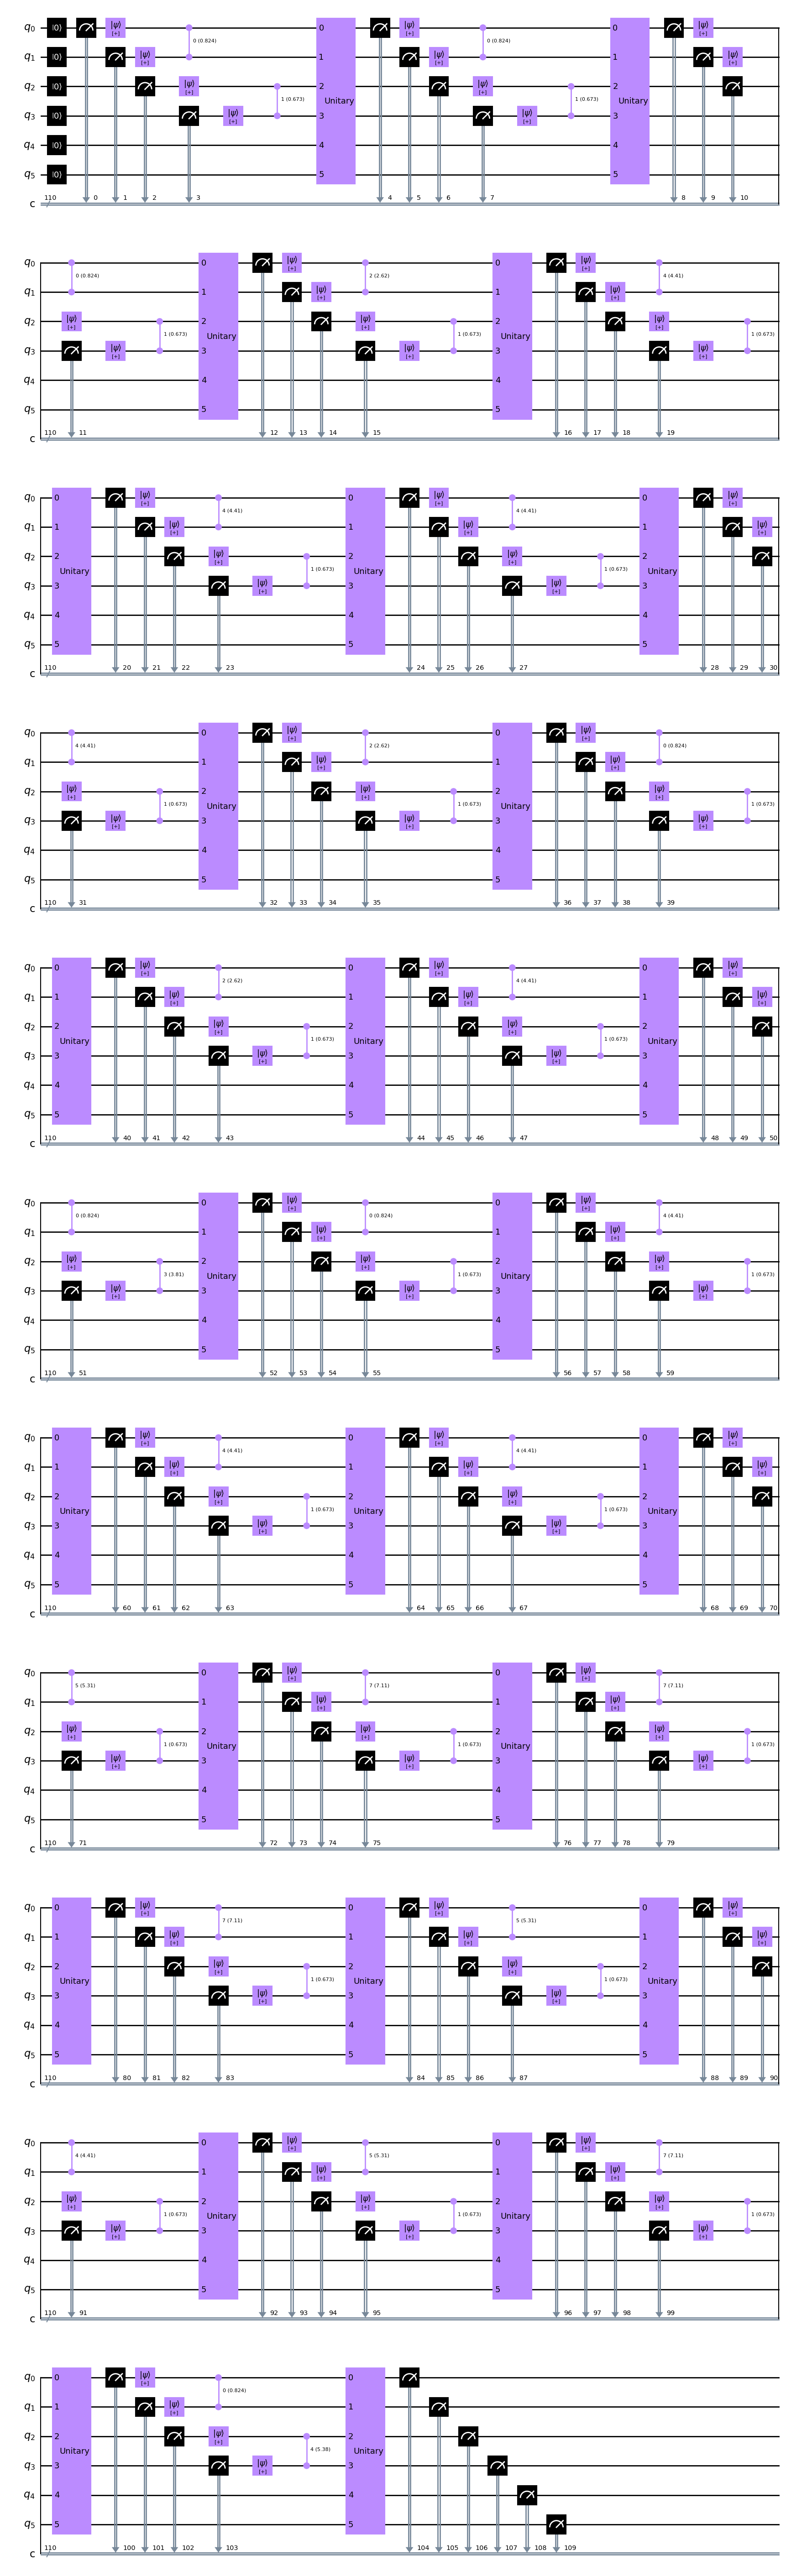

In [137]:
qres.circuit(timeseries_step, merge_registers=True, transpile=False).draw('mpl')

## Running

In [138]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS
)


Analyzing... : 100%|██████████| 130/130 [08:16<00:00,  3.82s/it]  


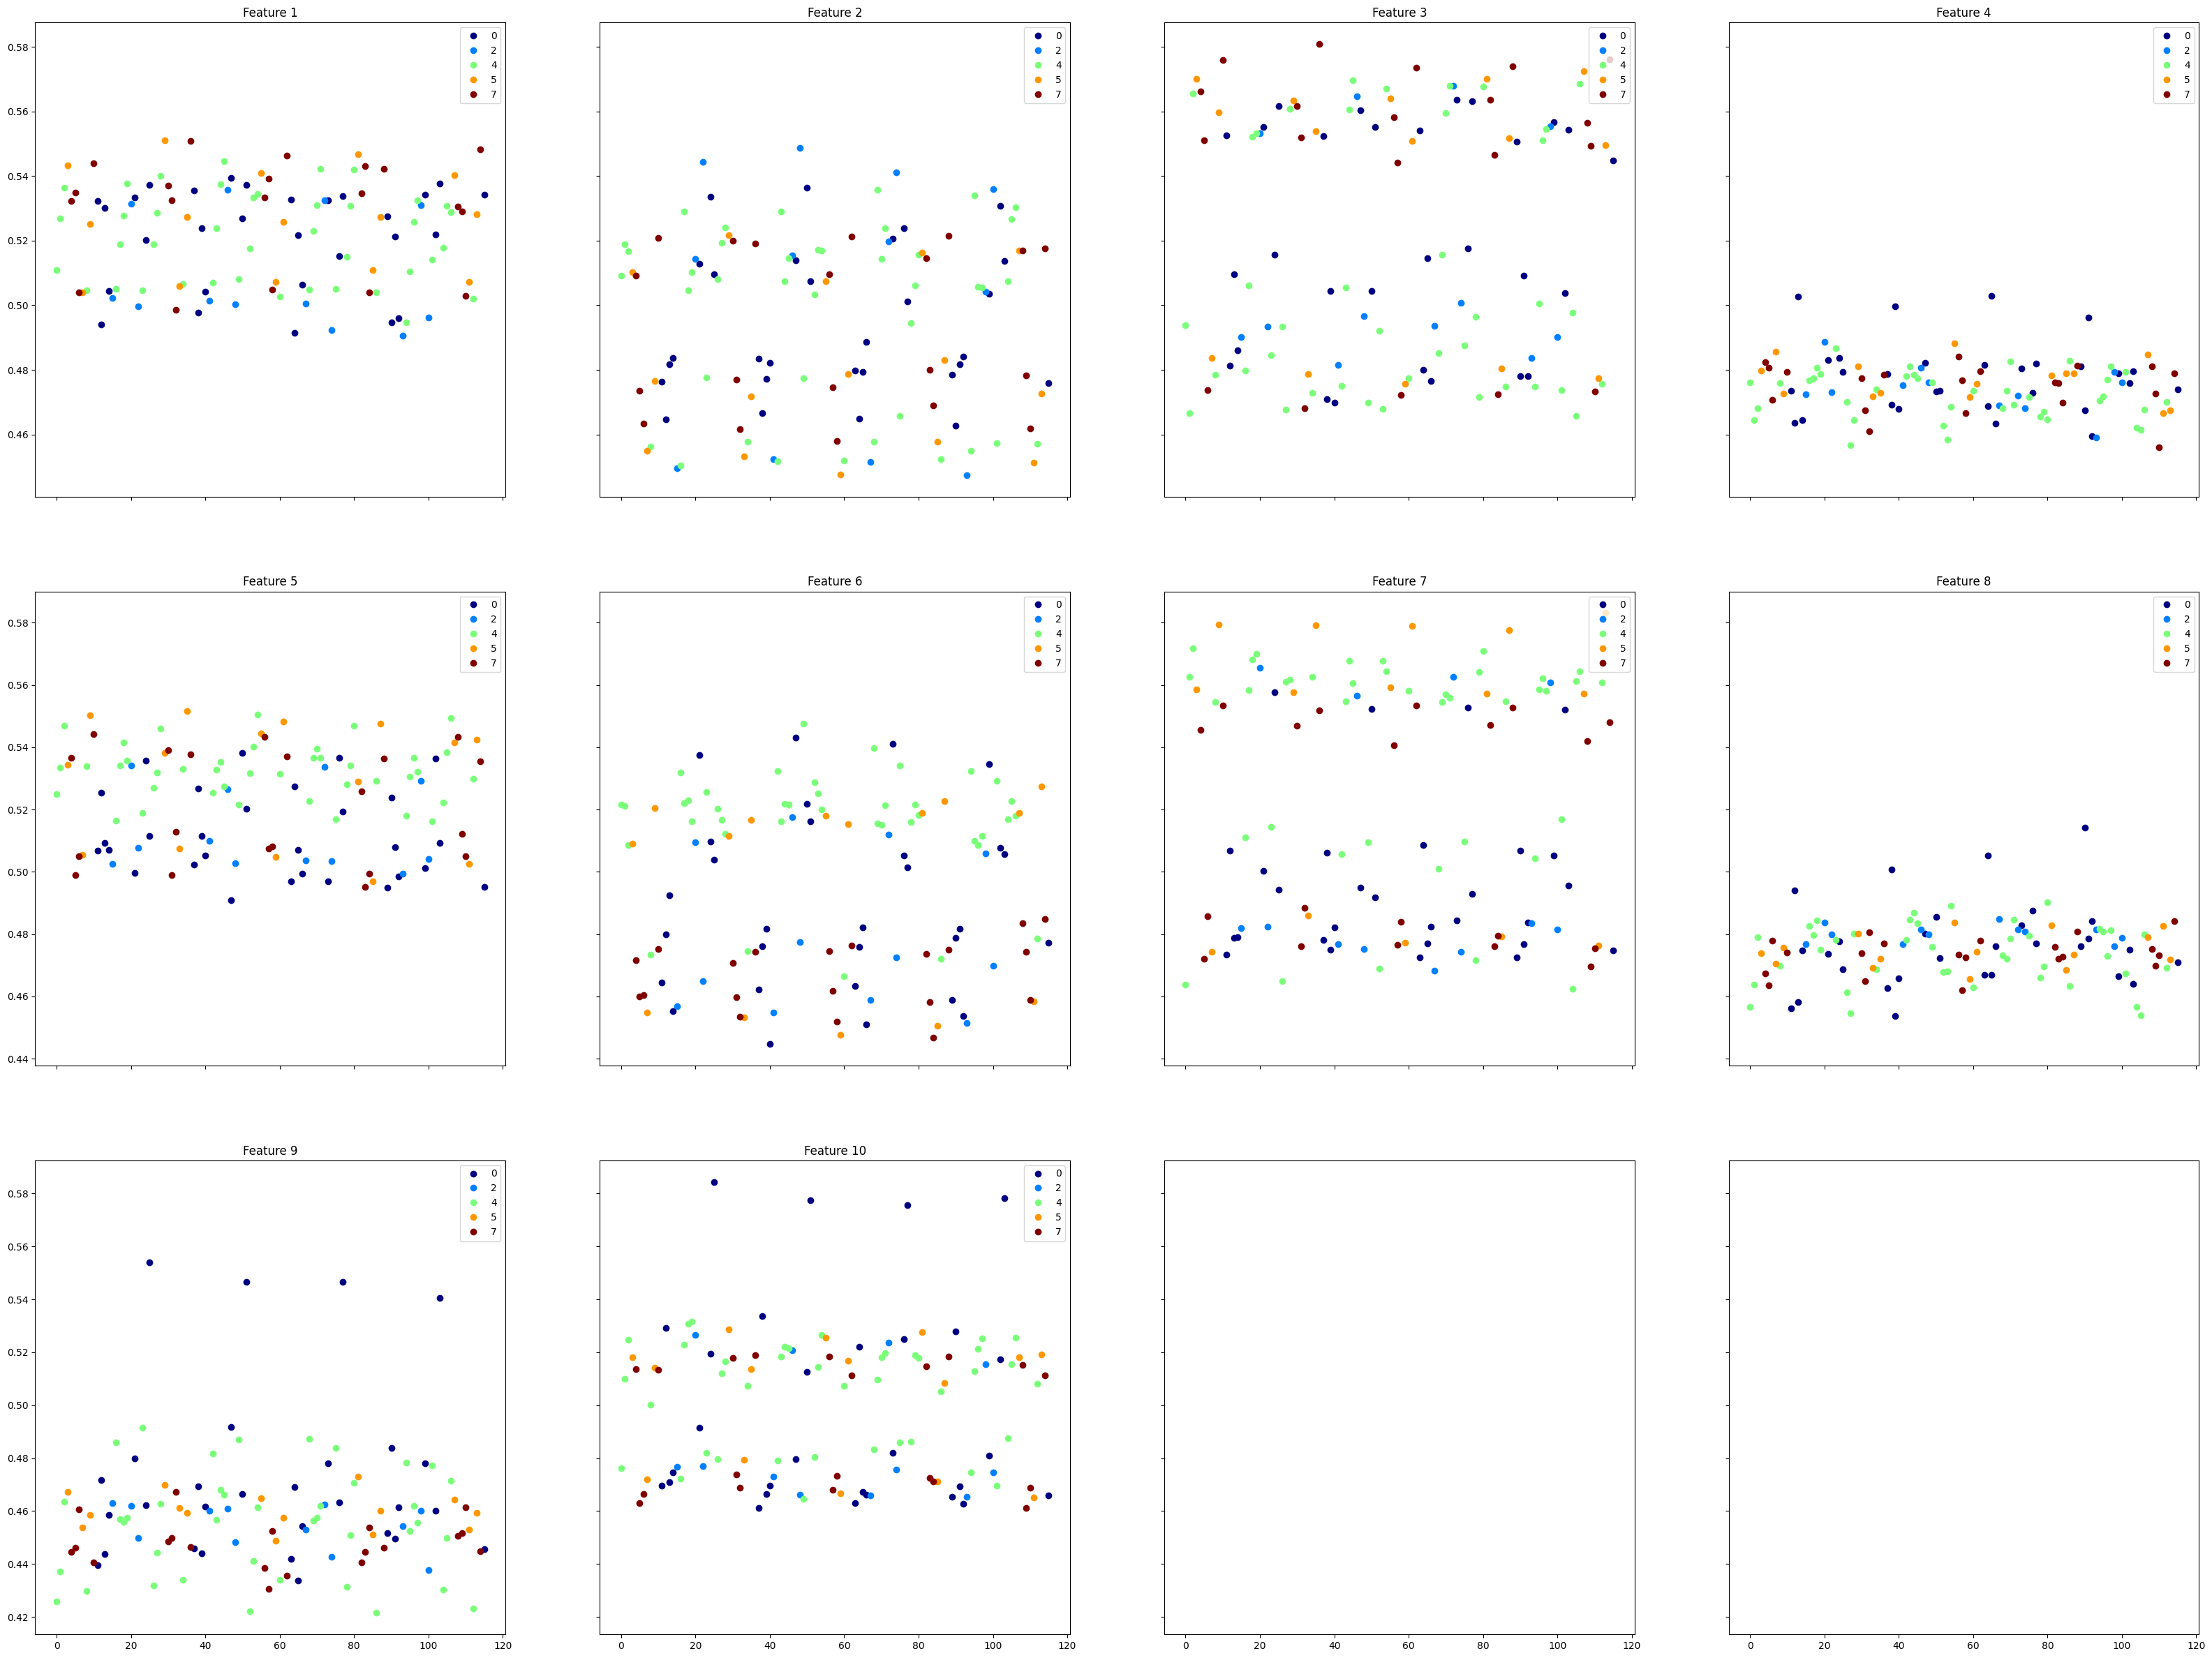

In [139]:
WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = np.array(timeseries[1:][warmup_idx:], dtype=int)
fig, ax = state_plotter(xstates, target[:, 0])

In [140]:
print(xstates.shape)

print(target.shape)

(116, 10)
(116, 2)


## Training

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
# models = np.array([
#     SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
# ] + [
#     RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 9)
# ] + [
#     KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
# ], dtype=object)




class ModelWrapper:
    def __init__(self, model):
        self.model = model


    def fit(self, X, y):
        self.models = np.array([clone(self.model) for _ in range(np.shape(y)[-1])])
        for i, _ in enumerate(self.models):
            self.models[i].fit(X, y[:, i])
        

    def score(self, X, y):
        self.scores = np.zeros(len(self.models))
        for i, model in enumerate(self.models):
            self.scores[i] = model.score(X, y[:, i])
        return np.average(self.scores)

    def predict(self, X):
        return np.array([
            model.predict(X) for model in self.models
        ]).flatten()

    def __str__(self):
        return str(self.models[0])





models = np.array(
    [Ridge(alpha=alpha) for alpha in np.linspace(0, 1e-3, 10)]
)

In [142]:


results = util.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of RidgeClassifier(alpha=0.0006938775510204082): 0.7675641025641028
Score of RidgeClassifier(alpha=0.000673469387755102): 0.7674358974358977
Score of RidgeClassifier(alpha=0.0009387755102040817): 0.7674358974358977
Score of RidgeClassifier(alpha=0.001): 0.7673076923076926
Score of RidgeClassifier(alpha=0.0008571428571428571): 0.7673076923076926
Score of RidgeClassifier(alpha=0.0009795918367346938): 0.7673076923076926
Score of RidgeClassifier(alpha=0.0006122448979591836): 0.7673076923076926
Score of RidgeClassifier(alpha=0.0009591836734693877): 0.7673076923076926
Score of RidgeClassifier(alpha=0.0006530612244897959): 0.7673076923076926
Score of RidgeClassifier(alpha=0.0007142857142857143): 0.7673076923076924
Score of RidgeClassifier(alpha=0.0006326530612244898): 0.7671794871794875
Score of RidgeClassifier(alpha=0.0007959183673469387): 0.7671794871794875
Score of RidgeClassifier(alpha=0.0007755102040816326): 0.7671794871794875
Score of RidgeClassifier(alpha=0.0009183673469387755): 

## Predicting

In [143]:
predict_from = timeseries_step
num_preds = 1*len(timeseries_step)


preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from
)


Predicting...: 100%|██████████| 26/26 [00:15<00:00,  1.67it/s]


In [144]:
print(preds)


[[5. 1.]
 [4. 1.]
 [4. 1.]
 [0. 1.]
 [7. 1.]
 [7. 1.]
 [7. 1.]
 [7. 1.]
 [0. 1.]
 [7. 1.]
 [2. 1.]
 [4. 1.]
 [4. 1.]
 [4. 1.]
 [0. 1.]
 [7. 1.]
 [0. 1.]
 [5. 1.]
 [4. 1.]
 [4. 1.]
 [4. 1.]
 [0. 1.]
 [2. 1.]
 [4. 1.]
 [4. 1.]
 [4. 1.]]


In [145]:
# true_values = timeseries

# pred_plot = np.append(predict_from, res)
# true_plot = np.append(predict_from, true_values)

# minlen = min(len(pred_plot), len(true_plot))

# plt.plot( true_plot[:minlen], label="True timeseries")
# plt.vlines(len(predict_from)-1, ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')
# plt.plot(pred_plot[:minlen], label="Predictions")
# plt.legend()



In [146]:
from ulid import ULID

# music_encoding = {
#     0: (52, 1),
#     1: (52, 1/4),
#     2: (54, 1/4),
#     3: (56, 1/4),
#     4: (57, 1/4),
#     5: (59, 1/4),
#     6: (56, 1/2),
#     7: (56, 1/8)
# }
notes = [
    (note + MIN_NOTE, length / 4) for note, length in timeseries_step
]+[
    (note + MIN_NOTE, length / 4) for note, length in preds
]

music.gen_audio(notes, filename=f"wav/{name}-{str(ULID())}.wav", BPM=160)